In [1]:
%matplotlib inline
import os, re
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.utils import make_grid
import torch.nn.functional as F

from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss
import lightly

from avalanche.models import SimpleCNN
from avalanche.benchmarks.datasets import CORe50Dataset

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd
from PIL import Image
import cv2

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
from lightly.models.modules import SimCLRProjectionHead
from lightly.loss import NTXentLoss

class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [4]:
resnet = lightly.models.ResNetGenerator('resnet-9')
backbone = nn.Sequential(*list(resnet.children())[:-1],nn.AdaptiveAvgPool2d(1))

# backbone = CoilCNNBackbone(in_channels = 3)

# simpleCNN = SimpleCNN()
# backbone = nn.Sequential(*list(simpleCNN.children())[:-1][0][:-2],nn.AdaptiveAvgPool2d(2))


model = SimCLR(backbone)
model = model.to(device)

model.train()
print("Model Loaded")

Model Loaded


In [5]:
# class ConcatDataset(torch.utils.data.Dataset):
#     def __init__(self, *datasets):
#         self.datasets = datasets

#     def __getitem__(self, i):
#         return tuple(d[i] for d in self.datasets)

#     def __len__(self):
#         return min(len(d) for d in self.datasets)

In [7]:
from torchvision.transforms import Compose, ToTensor, Resize
transform = Compose([ToTensor(),Resize((64,64))])

train_ds = CORe50Dataset(train=True, transform=transform, object_level=True)
test_ds = CORe50Dataset(train=False, transform=transform, object_level=True)
# dataset = CORe50Dataset(train=False, transform=transform, object_level=True)
# dataset = LightlyDataset.from_torch_dataset(dataset)
dataset = ConcatDataset([train_ds, test_ds])

Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified
Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified


In [33]:
def show_batch(dl, n_samples):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 30))
        ncol = 10
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=ncol, ncol=int(n_samples/ncol)).permute(1, 2, 0))
        return labels

tensor([40,  0, 11, 13, 20, 41, 46, 47,  0, 41, 20, 28,  0, 14, 41, 47,  5, 36,
        27, 46, 48, 11, 36,  6,  3, 46, 28, 18, 39,  4, 24, 47, 44, 32, 25, 47,
         5, 45,  9, 43, 27, 20, 20, 13, 41, 32,  9, 19, 27, 15, 13, 12, 28, 30,
        14, 43, 49, 12, 14, 40, 27, 16, 37,  7, 38, 26,  8, 44, 17, 33, 43, 33,
         5, 37, 22, 29, 18,  7, 32,  9, 36, 44, 14, 32, 21,  4, 11,  6, 43, 46,
         7, 21, 24, 47, 14,  9,  6,  7,  7, 36, 15, 38, 32, 32, 37, 31, 16, 22,
         4, 46, 25,  8, 14,  2, 16, 19,  5, 15, 31, 24,  7, 26, 37,  0,  4,  4,
        32,  8,  9, 22, 29, 43, 29, 23, 22,  8, 37,  1, 40, 33, 21, 15, 43,  2,
        13,  4, 18, 37, 43,  7, 40,  3, 37, 39,  5, 13,  3, 46,  3, 20,  5, 46,
        22, 26, 35, 45, 31, 48, 18, 47,  1, 23,  1, 39, 46, 27, 36, 40, 17, 47,
        17,  4, 30, 30, 13,  1, 27, 10, 46,  4,  3, 35, 18, 14, 23, 27, 28, 41,
        22, 42, 39, 15, 25, 15,  4, 26, 33,  2,  4, 25, 49, 33, 27, 28, 42, 49,
        27, 18, 40, 44, 43, 14, 46, 40, 

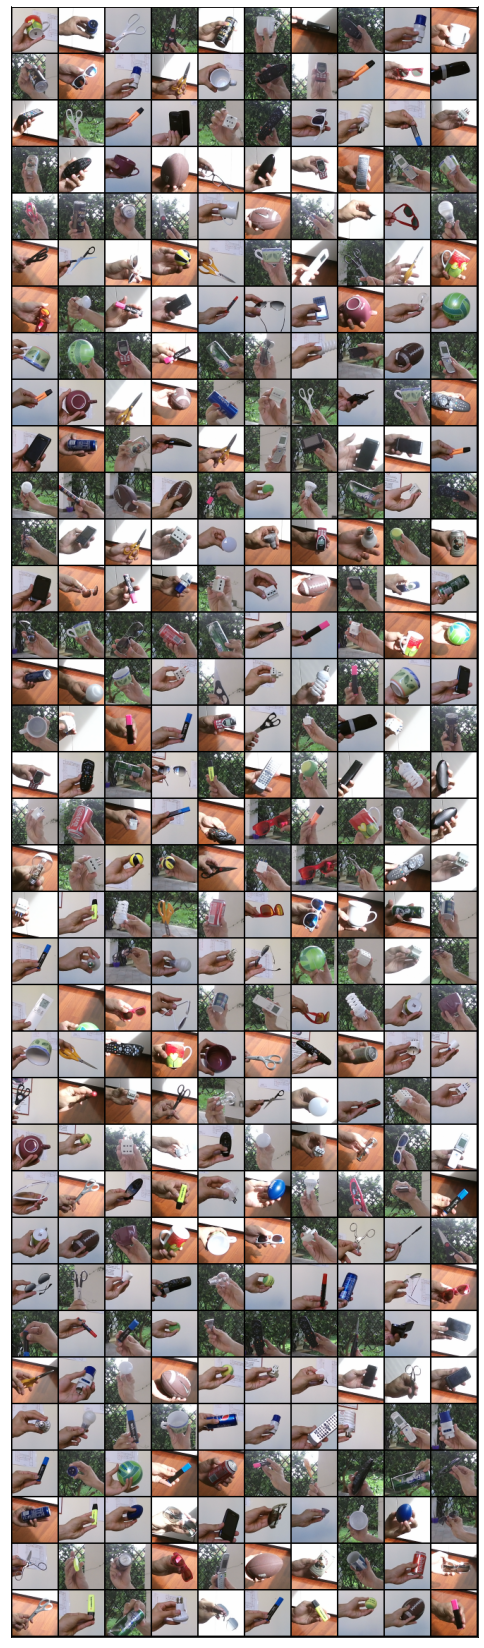

In [34]:
n_samples = 350
feat_ext_dl = DataLoader(test_ds, batch_size=n_samples, shuffle=True, num_workers=8)
show_batch(feat_ext_dl, n_samples=n_samples)

In [7]:
class TimePredictiveSampler():
    def __init__(self, dataset, batch_size, max_ts_future=5):
        if type(dataset) is ConcatDataset:
            self.targets = np.array(dataset.datasets[0].targets+dataset.datasets[1].targets)
        else:
            self.targets = np.array(dataset.targets)
            
        self.ds_len = len(self.targets)
        self.n_batches = self.ds_len // batch_size
        self.batch_size = batch_size
        self.max_ts_future=max_ts_future
        
    def __iter__(self):    
        batches = []
        for _ in range(self.n_batches):
            batch = []
            instances = np.random.choice(range(self.ds_len), self.batch_size)
            shifted_insts = np.zeros(shape=instances.shape, dtype=int)
            # for i, inst in enumerate(instances):
            #     rand_shift = np.random.choice(range(min(self.max_ts_future,(300-i%300))), 1)          
            #     shifted_insts[i] = inst + rand_shift
            shifted_insts = instances + np.random.choice(range(self.max_ts_future), instances.shape)
            shifted_insts = np.clip(shifted_insts, a_min=0, a_max=self.ds_len - 1)
            overflown = (self.targets[instances] != self.targets[shifted_insts])
            shifted_insts[overflown] = (shifted_insts - self.max_ts_future)[overflown]
            batch.extend(instances)
            batch.extend(shifted_insts)
    
            batches.append(batch)
        
        return iter(batches)
        
    def __len__(self):
        return self.n_batches
        
        

In [8]:
model.backbone.load_state_dict(torch.load("/home/ehajizad/ss_learning/neuromorphic-continual-learning/models/core50_simsiam_resnet9.pth"))


<All keys matched successfully>

In [8]:
s = TimePredictiveSampler(dataset, 256, 50)
dataloader = DataLoader(dataset,num_workers=8,batch_sampler=s)

In [ ]:
print("Starting Training")

criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

training_loss = []

for epoch in range(100):
    model.train()
    total_loss = 0
    total_bt_loss = 0
    total_norm_loss = 0
    for i, (x, _) in enumerate(dataloader):
        x0,x1 = x.split(int(x.shape[0]/2), dim=0)
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f} ")
    training_loss.append(avg_loss)
    


Starting Training


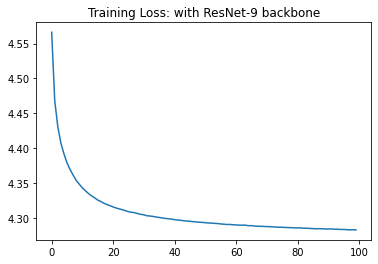

In [10]:
ax1 = plt.subplot()
plt.title("Training Loss: with ResNet-9 backbone")
training_loss_np = torch.tensor(training_loss, device = 'cpu')
l1, = ax1.plot(training_loss_np)

In [11]:
torch.save(model.backbone.state_dict(), "/home/ehajizad/ss_learning/neuromorphic-continual-learning/models/core50_simclr_resnet9_future_50_full_data.pth")

In [8]:
model.backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, 

In [18]:
from torchvision import models
from torchinfo import summary
model = model.backbone[0:-1]
model.eval()
summary(model, (1,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 8, 8]            --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─Conv2d: 3-3                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 64, 64]           128
│    │    └─Sequential: 3-5              [1, 64, 64, 64]           --
├─Sequential: 1-4                        [1, 128, 32, 32]          --
│    └─BasicBlock: 2-2                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-6                  [1, 128, 32, 32]          73,7